In [1]:
%%capture

!apt-get update && apt-get install -y xvfb
!pip install swig
!pip install gymnasium pyvirtualdisplay

#### Setup virtual display

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [3]:
import copy
import gymnasium as gym
import torch
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML, clear_output
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [4]:
def display_video(episode=0):
    video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

In [5]:
def plot(
        episode,
        scores,
        losses,
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('frame %s. score: %s' % (episode, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(122)
        plt.title('loss')
        plt.plot(losses)
        plt.show()

#### Create the Deep Q-Network

In [6]:
class DQN(nn.Module):

    def __init__(self, hidden_size, obs_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x.float())


#### Create the policy

In [7]:
def epsilon_greedy(state, env, net, epsilon=0.0):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state = torch.tensor([state]).to(device)
        q_values = net(state)
        _, action = torch.max(q_values, dim=1)
        action = int(action.item())
    return action

#### Create the replay buffer

In [8]:
class ReplayBuffer:

    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = np.array([None] * capacity)
        self.position = 0
        self.size = 0

    def append(self, transition):
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity
        if self.size < self.capacity:
            self.size += 1

    def sample(self, batch_size):
        idxs = np.random.choice(self.size, size=batch_size, replace=False)
        # idxs.shape: [batch_size]
        batch = self.memory[idxs]
        # batch.shape: [batch_size, (state, action, reward, done, next_state)]
        # batch.shape: [batch_size, 5]

        batch = zip(*batch)
        # batch.shape: [5, batch_size]
        batch = [torch.tensor(items) for items in batch]
        return batch

    def __len__(self):
        return self.size

#### Create the environment

In [9]:
def create_environment(name):
    env = gym.make(name, max_episode_steps=200, render_mode="rgb_array")
    env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

In [10]:
env = create_environment('CartPole-v1')

for episode in range(10):
    done = False
    env.reset()
    while not done:
        action = env.action_space.sample()
        _, _, done, _, = env.step(action)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [11]:
action = env.action_space.sample()
observation, reward, terminated, truncated = env.step(action)
observation, reward, terminated, truncated

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


(array([-0.18174253, -1.2249131 ,  0.27514094,  2.207812  ], dtype=float32),
 0.0,
 True,
 {'episode': {'r': np.float32(0.0), 'l': np.int32(1), 't': 2.259179},
  'TimeLimit.truncated': False})

In [12]:
input_tensor = torch.tensor([10, 20, 30, 40, 50])
index_tensor = torch.tensor([0, 2, 1, 4]) # Indices to select
dim = 0

output_tensor = torch.gather(input_tensor, dim, index_tensor)

print("Input Tensor:\n", input_tensor)
print("Index Tensor:\n", index_tensor)
print("Dimension (dim):", dim)
print("Output Tensor:\n", output_tensor)

Input Tensor:
 tensor([10, 20, 30, 40, 50])
Index Tensor:
 tensor([0, 2, 1, 4])
Dimension (dim): 0
Output Tensor:
 tensor([10, 30, 20, 50])


In [13]:
def deep_q_learning(q_network,
                    optimizer,
                    policy,
                    env,
                    device,
                    episodes=10000,
                    batch_size=32,
                    memory_size=10_000,
                    gamma=0.99,
                    max_epsilon=1.,
                    min_epsilon=0.1,
                    sync_rate=10,
                    epsilon_decay = 1 / 2000):
    epsilon = max_epsilon
    q_network = q_network.to(device)
    target_q_network = copy.deepcopy(q_network).to(device)
    target_q_network.eval()
    memory = ReplayBuffer(capacity=memory_size)
    stats = {'MSE Loss': [], 'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()[0]
        done = False
        ep_return = 0
        while not done:
            epsilon = max(
                    min_epsilon, epsilon - (
                        max_epsilon - min_epsilon
                    ) * epsilon_decay
                )
            action = policy(state, env, model, epsilon)
            # print(state)
            next_state, reward, done, _ = env.step(action)

            memory.append([state, action, reward, done, next_state])

            if len(memory) > batch_size:
                states, actions, rewards, dones, next_states = memory.sample(batch_size)
                states = states.to(device)
                next_states = next_states.to(states)
                actions = actions.unsqueeze(1).to(device)
                rewards = rewards.unsqueeze(1).to(device)
                dones = dones.unsqueeze(1).to(device)
                qsa_b = q_network(states).gather(1, actions)
                with torch.no_grad():
                    next_qsa_b = target_q_network(next_states)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0].detach()

                target_b = rewards + ~dones * gamma * next_qsa_b
                loss = F.smooth_l1_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optimizer.step()

                stats['MSE Loss'].append(loss.item())

            state = next_state
            ep_return += reward


        stats['Returns'].append(ep_return)
        if episode % 100 == 0:
            print(f'Episode: {episode}, Return: {ep_return}')
        if episode % sync_rate == 0:
            plot(episode, stats['Returns'], stats['MSE Loss'])
            target_q_network.load_state_dict(q_network.state_dict())
            target_q_network.eval()
    return stats


In [14]:
env.observation_space.shape

(4,)

In [15]:
env.observation_space.shape[0], env.action_space.n

(4, np.int64(2))

In [16]:
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
model = DQN(hidden_size=128, obs_size=obs_size, n_actions=n_actions)
optim = AdamW(model.parameters(), lr=0.0005)

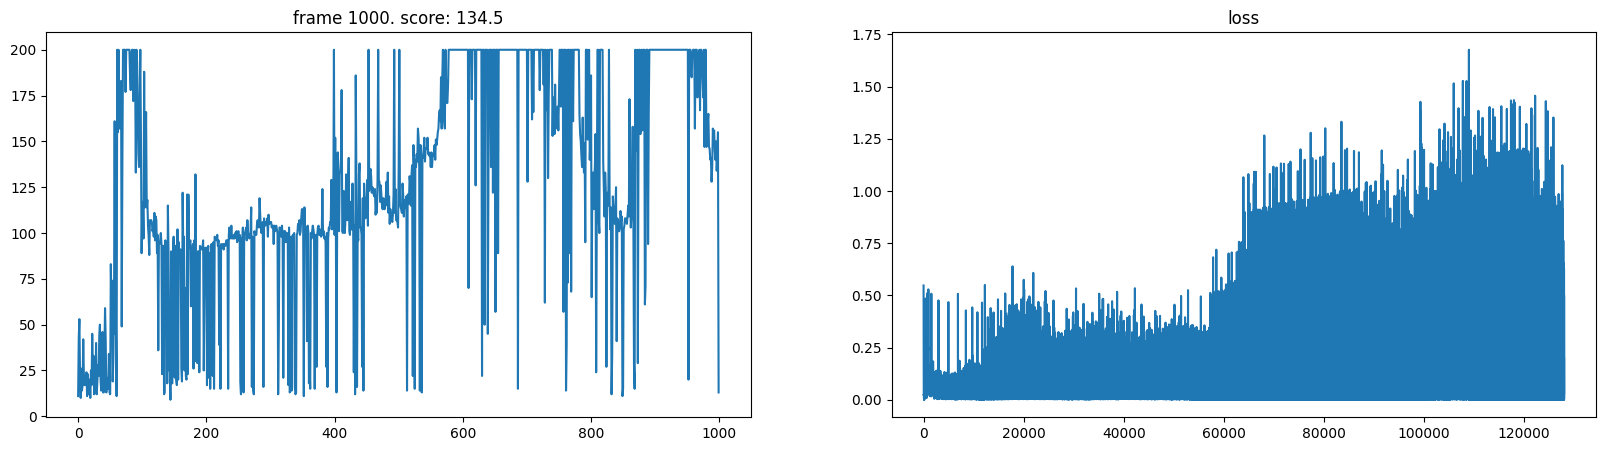

100%|██████████| 1000/1000 [16:22<00:00,  1.02it/s]


In [17]:
stats = deep_q_learning(q_network=model,
                    optimizer=optim,
                    policy=epsilon_greedy,
                    env=env,
                    device=device,
                    episodes=1000,
                    batch_size=256,
                    memory_size=10_000,
                    gamma=0.99,
                    max_epsilon=1.,
                    min_epsilon=0.1,
                    sync_rate=10,
                    epsilon_decay = 1 / 2000)

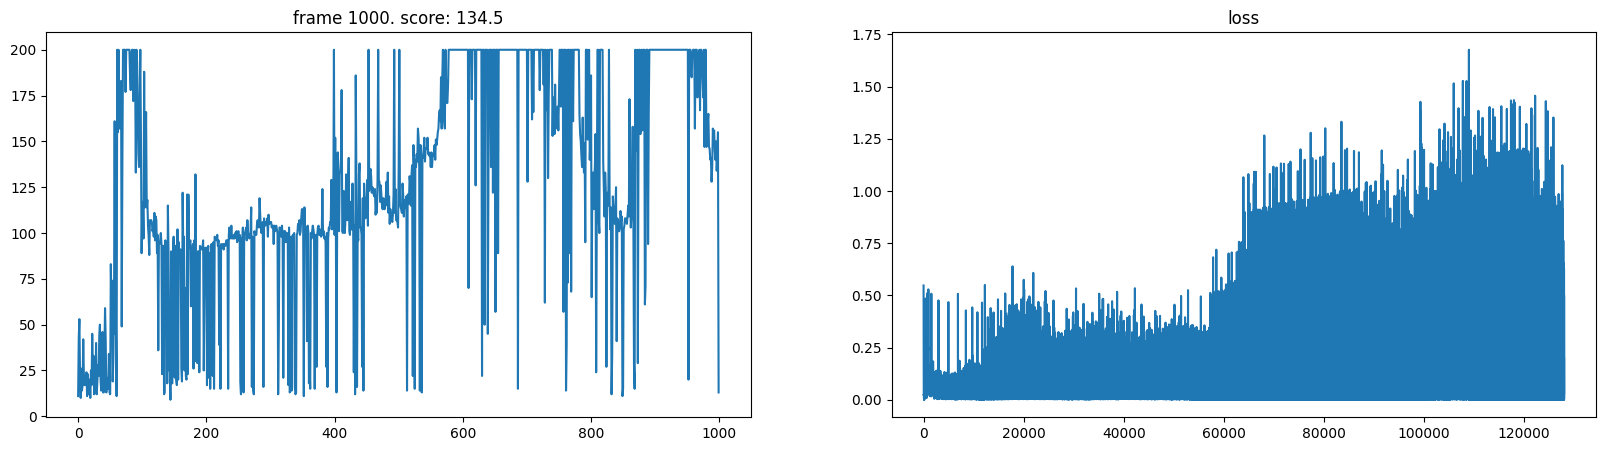

In [18]:
plot(len(stats['Returns']), stats['Returns'], stats['MSE Loss'])

In [19]:
display_video(episode=750)